[INFO] Using device: cpu
[INFO] feature_names (C=15): ['b_cm', 'EMG_ch1_env', 'EMG_ch2_env', 'EMG_ch3_env', 'EMG_ch4_env', 'EMG_ch5_env', 'EMG_ch6_env', 'EMG_ch7_env', 'EMG_ch8_env', 'ACCmag_Pelvis', 'ACCmag_T8', 'ACCmag_Head', 'COM_ch1', 'COM_ch2', 'COM_ch3']
[INFO] Loaded: tcn_dataset_b_emg_com_future_multihorizon_missteps.npz
[INFO] X.shape = (11367, 5, 15)  (N, L, C)
[INFO] labels_multi.shape = (11367, 10)  (N, H)
[INFO] horizons = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] target_fs = 50.0
[INFO] input_window_sec = 0.1
[INFO] Positive ratio per horizon:
  +0.10s: 0.059206
  +0.20s: 0.085159
  +0.30s: 0.111111
  +0.40s: 0.137063
  +0.50s: 0.162928
  +0.60s: 0.187824
  +0.70s: 0.212281
  +0.80s: 0.235682
  +0.90s: 0.257500
  +1.00s: 0.278614
[INFO] any_pos ratio (any horizon positive) = 0.278614
[INFO] Unique subjects = 10
[INFO] Example trial_id -> subject_id:
  S1-pr-TWEO-G-T2.xdf -> S1
  S1-pr-TWEO-G-T2.xdf -> S1
  S1-pr-TWEO-G-T2.xdf -> S1
  S1-pr-TWEO-G-T2.xdf -> S1
  S1-

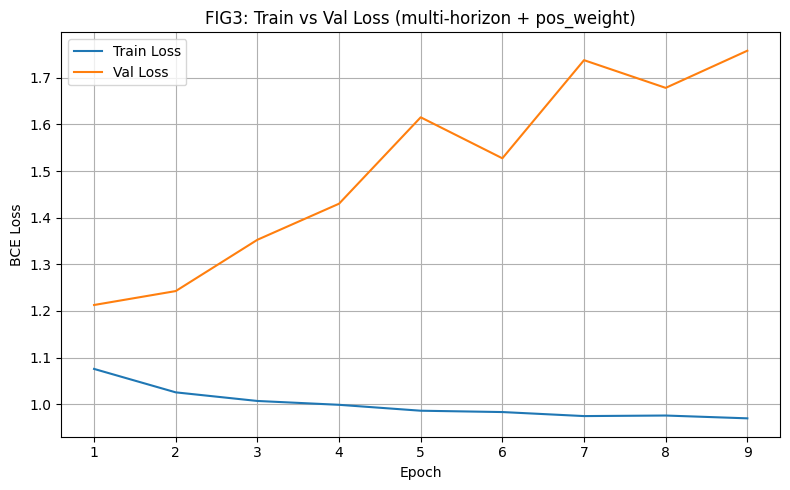

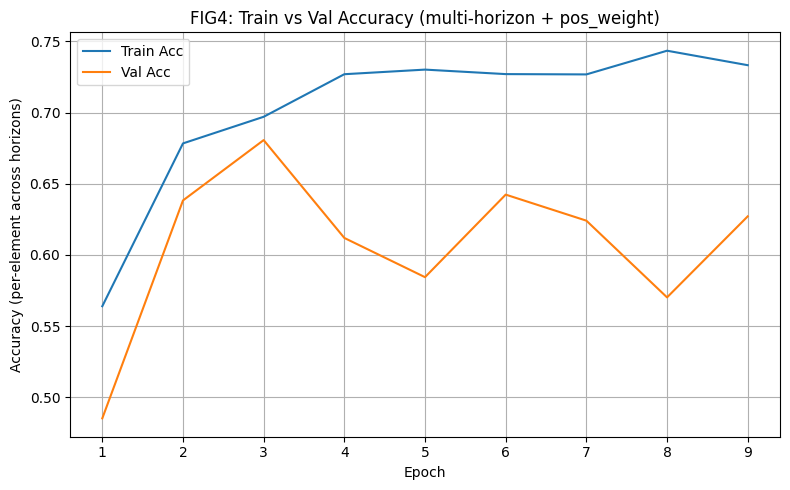

[SAVED] Plots: train_val_loss.png, train_val_accuracy.png


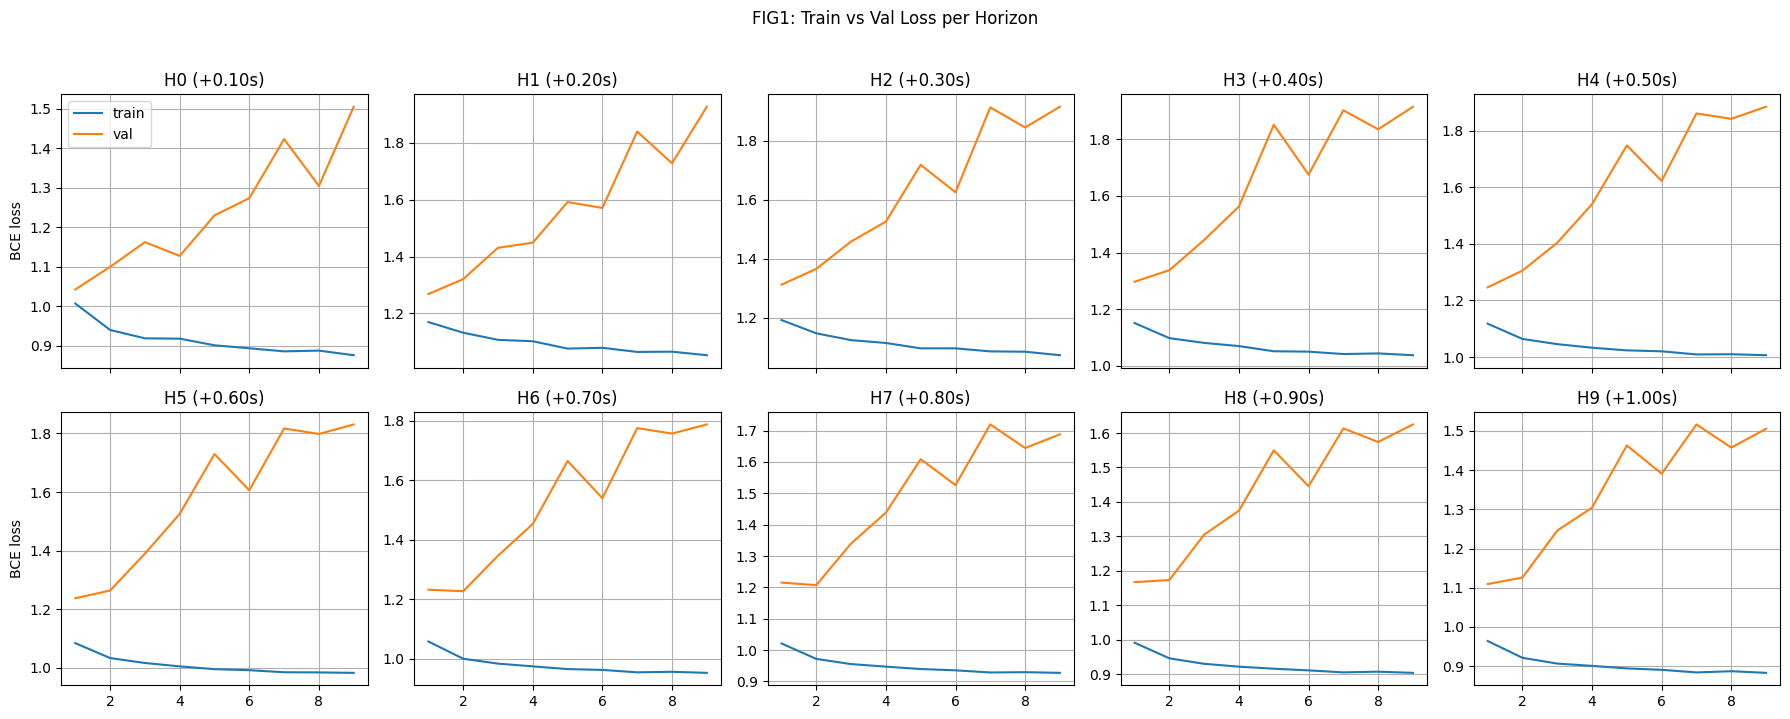

[SAVED] Plot: fig1_loss_per_horizon.png


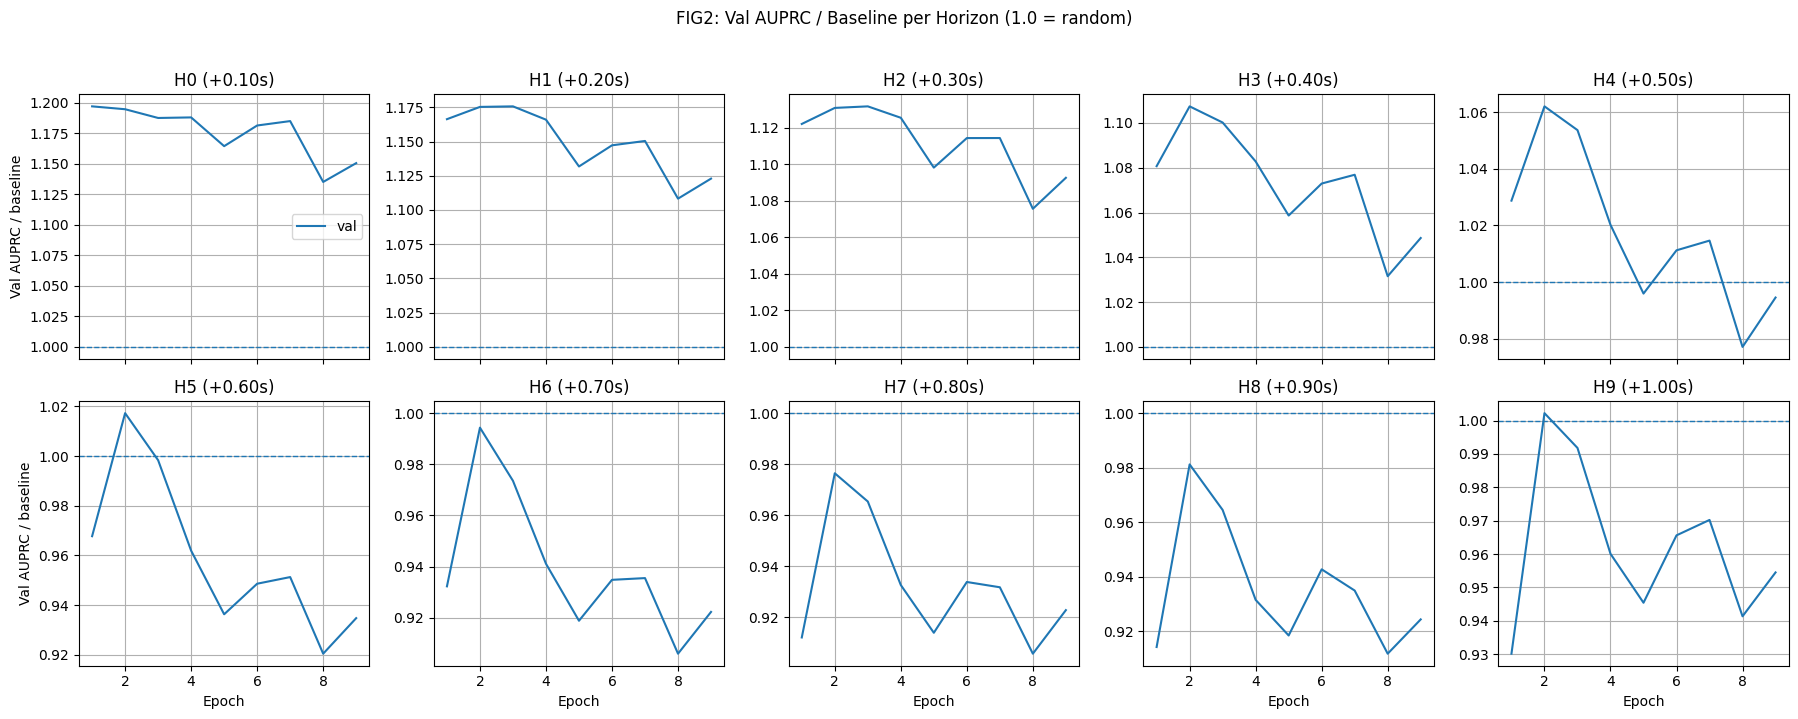

[SAVED] Plot: fig2_val_auprc_over_baseline_per_horizon.png


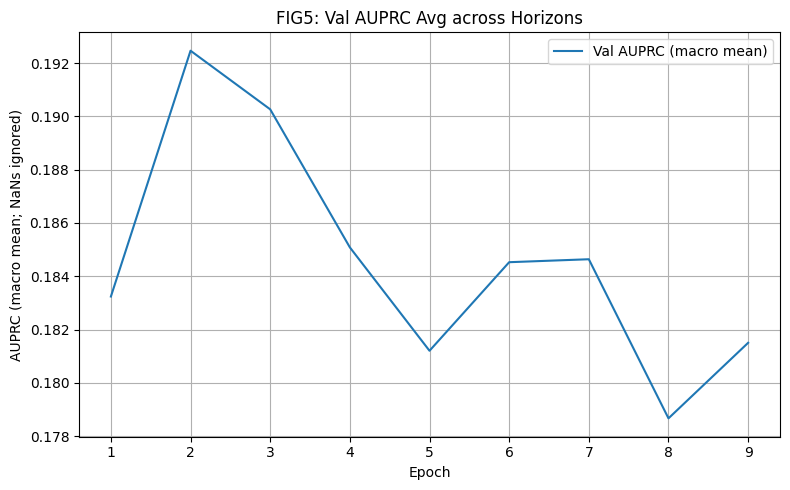

[SAVED] Plot: fig5_val_auprc_avg.png


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_tcn_multihorizon_posweight.py

Train a multi-output Temporal Convolutional Network (TCN) for multi-horizon
binary classification from an NPZ dataset.

Adds (minimal changes from your working code):
  - EARLYSTOP_MODE: choose checkpoint criterion based on val loss:
      * "all"    -> mean val loss over all horizons
      * "subset" -> mean val loss over selected horizons
      * "single" -> val loss of a single horizon
  - Fig 1: train vs val loss curves per horizon (10 subplots)
  - Fig 2: val-only AUPRC/baseline per horizon (10 subplots), baseline line at 1.0
  - Fig 5: averaged (macro) val AUPRC across horizons curve

IMPORTANT FIX (this update):
  - Per-horizon TRAIN/VAL losses are now accumulated WEIGHTED BY BATCH SIZE.
    This makes val_loss_per_h consistent with scalar val_loss, and therefore
    makes stop_score "correct" (not biased by equal-weighting batches).

Notes:
  - Training still uses BCEWithLogitsLoss with pos_weight (computed on TRAIN only).
  - Safe handling if a horizon has 0 positives (or all positives) in val: AUPRC becomes NaN (no crash).
"""

import os
import csv
import math
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt


# =========================
# User config
# =========================

NPZ_TCN_DATA = "tcn_dataset_b_emg_com_future_multihorizon_missteps.npz"
CKPT_IN = None                       # optional: path to an existing .pt for finetuning
MODEL_OUT = "tcn_multihorizon_best.pt"

BATCH_SIZE = 128
MAX_EPOCHS = 80
PATIENCE = 8
LR = 1e-3
WEIGHT_DECAY = 1e-5

POS_WEIGHT_CLIP_MIN = 0.5
POS_WEIGHT_CLIP_MAX = 10.0

VAL_SPLIT = 0.2
SEED = 42

# ---- Split mode ----
SPLIT_MODE = "subject"   # {"window","trial","subject"}

# ---- Imbalance minimization for trial/subject splits ----
SPLIT_MAX_TRIES = 80
IMBALANCE_ABS_TOL = 0.05

# ---- Early-stopping / best checkpoint criterion ----
# Uses VAL per-horizon loss (computed with same pos_weight).
# "all"    -> mean over all horizons
# "subset" -> mean over EARLYSTOP_H_IDXS
# "single" -> just horizon EARLYSTOP_SINGLE_H
EARLYSTOP_MODE = "all"       # {"all","subset","single"}
EARLYSTOP_H_IDXS = [0, 1, 2] # used if EARLYSTOP_MODE=="subset"
EARLYSTOP_SINGLE_H = 0       # used if EARLYSTOP_MODE=="single"

# Outputs (keep your originals for Fig3/Fig4)
HISTORY_CSV = "training_history.csv"
LOSS_PNG = "train_val_loss.png"         # Fig 3
ACC_PNG = "train_val_accuracy.png"      # Fig 4

# New figures
FIG1_LOSS_PER_H_PNG = "fig1_loss_per_horizon.png"
FIG2_VAL_AUPRC_PER_H_PNG = "fig2_val_auprc_over_baseline_per_horizon.png"
FIG5_VAL_AUPRC_AVG_PNG = "fig5_val_auprc_avg.png"


# =========================
# Reproducibility
# =========================

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)


# =========================
# Dataset
# =========================

class SeqDataset(Dataset):
    """
    X: (N, L, C)
    labels_multi: (N, H)
    Returns:
      x: (C, L) float32
      y: (H,)   float32
    """
    def __init__(self, X: np.ndarray, labels_multi: np.ndarray):
        self.X = X.astype(np.float32)
        self.y = labels_multi.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]                 # (L, C)
        x = np.transpose(x, (1, 0))     # (C, L) for Conv1d
        y = self.y[idx]                 # (H,)
        return torch.from_numpy(x), torch.from_numpy(y)


# =========================
# Model
# =========================

class SimpleTCN(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_horizons: int,
        hidden_channels: int = 64,
        num_layers: int = 4,
        kernel_size: int = 3,
        dropout: float = 0.1,
    ):
        super().__init__()

        layers = []
        c_in = in_channels
        for i in range(num_layers):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            layers.append(
                nn.Sequential(
                    nn.Conv1d(c_in, hidden_channels, kernel_size,
                              padding=padding, dilation=dilation),
                    nn.BatchNorm1d(hidden_channels),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                )
            )
            c_in = hidden_channels

        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_channels, out_horizons)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, L)
        returns logits: (B, H)
        """
        feat = self.tcn(x)              # (B, hidden, L')
        feat = self.global_pool(feat)   # (B, hidden, 1)
        feat = feat.squeeze(-1)         # (B, hidden)
        logits = self.fc(feat)          # (B, H)
        return logits


# =========================
# Device
# =========================

def get_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


# =========================
# Utilities
# =========================

def compute_pos_weight(labels_multi: np.ndarray, clip_min=0.5, clip_max=10.0) -> np.ndarray:
    """
    labels_multi: (N, H) 0/1
    pos_weight[h] = neg/pos
    """
    pos_ratio = labels_multi.mean(axis=0)          # (H,)
    neg_ratio = 1.0 - pos_ratio
    pw = neg_ratio / np.maximum(pos_ratio, 1e-6)
    pw = np.clip(pw, clip_min, clip_max)
    return pw.astype(np.float32)


def save_history_csv(path: str, history: dict):
    """
    Keep your original CSV fields intact (minimal disruption).
    """
    fields = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fields)
        writer.writeheader()
        for i in range(len(history["epoch"])):
            writer.writerow({k: history[k][i] for k in fields})


def plot_curves(history: dict, loss_png: str, acc_png: str):
    epochs = history["epoch"]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.title("FIG3: Train vs Val Loss (multi-horizon + pos_weight)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(loss_png, dpi=200)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (per-element across horizons)")
    plt.title("FIG4: Train vs Val Accuracy (multi-horizon + pos_weight)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_png, dpi=200)
    plt.show()


def normalize_trial_id(s: str) -> str:
    s = str(s).strip()
    s = os.path.basename(s)
    return s


def trial_id_to_subject_id(trial_id: str) -> str:
    tid = normalize_trial_id(trial_id)
    subj = tid.split("-")[0].strip()
    return subj


def horizon_stats_str(y: np.ndarray, label: str, horizons) -> str:
    pr = y.mean(axis=0)
    parts = []
    for i, h in enumerate(horizons):
        try:
            parts.append(f"+{float(h):.2f}s={pr[i]:.4f}")
        except Exception:
            parts.append(f"h[{i}]={pr[i]:.4f}")
    return f"{label}: " + " | ".join(parts)


def split_quality(y_train: np.ndarray, y_val: np.ndarray) -> dict:
    """
    Requirements (per horizon, in BOTH splits):
      - at least 1 positive
      - at least 1 negative
    Score:
      - max absolute difference in positive rate across horizons
    """
    H = y_train.shape[1]

    train_pos = y_train.sum(axis=0)
    val_pos   = y_val.sum(axis=0)

    train_n = y_train.shape[0]
    val_n   = y_val.shape[0]

    train_neg = train_n - train_pos
    val_neg   = val_n - val_pos

    ok = True
    reasons = []

    for h in range(H):
        if train_pos[h] < 1:
            ok = False; reasons.append(f"h{h}: train_pos=0")
        if val_pos[h] < 1:
            ok = False; reasons.append(f"h{h}: val_pos=0")
        if train_neg[h] < 1:
            ok = False; reasons.append(f"h{h}: train_neg=0")
        if val_neg[h] < 1:
            ok = False; reasons.append(f"h{h}: val_neg=0")

    pr_tr = y_train.mean(axis=0)
    pr_va = y_val.mean(axis=0)
    max_abs_diff = float(np.max(np.abs(pr_tr - pr_va))) if H > 0 else 0.0

    return {
        "ok": ok,
        "reasons": reasons,
        "max_abs_diff": max_abs_diff,
        "pr_train": pr_tr,
        "pr_val": pr_va,
    }


def choose_best_unit_split(
    unit_ids: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    val_split: float,
    seed: int,
    max_tries: int,
    abs_tol: float,
):
    unit_ids = unit_ids.astype(str)
    unique_units = np.unique(unit_ids)

    if len(unique_units) < 2:
        raise RuntimeError(f"Cannot split: only {len(unique_units)} unique units found.")

    n_val = max(1, int(round(val_split * len(unique_units))))
    if len(unique_units) - n_val < 1:
        n_val = len(unique_units) - 1

    best = None
    best_masks = None

    for k in range(max_tries):
        rs = seed + k * 997

        train_units, val_units = train_test_split(
            unique_units,
            test_size=n_val,
            random_state=rs,
            shuffle=True,
        )

        train_mask = np.isin(unit_ids, train_units)
        val_mask   = np.isin(unit_ids, val_units)

        if train_mask.sum() == 0 or val_mask.sum() == 0:
            continue
        if np.any(train_mask & val_mask):
            continue

        y_train = y[train_mask]
        y_val   = y[val_mask]

        info = split_quality(y_train, y_val)
        if not info["ok"]:
            continue

        if (best is None) or (info["max_abs_diff"] < best["max_abs_diff"]):
            best = info
            best_masks = (train_mask, val_mask, train_units, val_units)
            if best["max_abs_diff"] <= abs_tol:
                break

    if best is None or best_masks is None:
        raise RuntimeError(
            "Could not find a usable unit-based split that has non-zero positives and negatives "
            "per horizon in both train and val."
        )

    train_mask, val_mask, train_units, val_units = best_masks
    return train_mask, val_mask, train_units, val_units, best


# ---- Helpers: per-horizon loss + AUPRC ----

def bce_per_horizon_torch(logits: torch.Tensor, targets: torch.Tensor, pos_weight: torch.Tensor) -> torch.Tensor:
    """
    logits:  (B,H)
    targets: (B,H)
    pos_weight: (H,)
    return: (H,) mean loss per horizon for that batch
    """
    loss_elem = F.binary_cross_entropy_with_logits(
        logits, targets, pos_weight=pos_weight, reduction="none"
    )  # (B,H)
    return loss_elem.mean(dim=0)  # (H,)


def safe_auprc_per_horizon(y_true: np.ndarray, y_score: np.ndarray) -> np.ndarray:
    """
    Returns (H,) AUPRC, with NaN if undefined (no positives or all positives).
    """
    H = y_true.shape[1]
    out = np.full((H,), np.nan, dtype=np.float32)
    for h in range(H):
        yt = y_true[:, h].astype(int)
        ys = y_score[:, h].astype(float)

        # Undefined if no positives OR no negatives
        if yt.sum() == 0 or yt.sum() == len(yt):
            out[h] = np.nan
            continue
        try:
            out[h] = float(average_precision_score(yt, ys))
        except Exception:
            out[h] = np.nan
    return out


def macro_mean_ignore_nan(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    if np.all(~np.isfinite(x)):
        return float("nan")
    return float(np.nanmean(x))


def get_earlystop_indices(H: int):
    mode = EARLYSTOP_MODE.lower().strip()
    if mode == "all":
        return list(range(H)), "all"
    if mode == "subset":
        idxs = [int(i) for i in EARLYSTOP_H_IDXS]
        if len(idxs) == 0:
            raise ValueError("EARLYSTOP_MODE='subset' but EARLYSTOP_H_IDXS is empty.")
        if min(idxs) < 0 or max(idxs) >= H:
            raise ValueError(f"EARLYSTOP_H_IDXS out of range for H={H}: {idxs}")
        return idxs, f"subset={idxs}"
    if mode == "single":
        idx = int(EARLYSTOP_SINGLE_H)
        if idx < 0 or idx >= H:
            raise ValueError(f"EARLYSTOP_SINGLE_H out of range for H={H}: {idx}")
        return [idx], f"single={idx}"
    raise ValueError("EARLYSTOP_MODE must be one of: 'all', 'subset', 'single'")


# ---- Plotting: Fig1, Fig2, Fig5 ----

def plot_fig1_loss_per_horizon(history_full: dict, horizons, out_png: str):
    epochs = np.array(history_full["epoch"])
    train_L = np.array(history_full["train_loss_per_h"], dtype=float)  # (E,H)
    val_L   = np.array(history_full["val_loss_per_h"], dtype=float)    # (E,H)
    H = train_L.shape[1]

    nrows, ncols = (2, 5) if H == 10 else (int(math.ceil(H / 5)), 5)
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 7), sharex=True)
    axes = np.array(axes).reshape(-1)

    for h in range(H):
        ax = axes[h]
        ax.plot(epochs, train_L[:, h], label="train")
        ax.plot(epochs, val_L[:, h], label="val")
        try:
            ax.set_title(f"H{h} (+{float(horizons[h]):.2f}s)")
        except Exception:
            ax.set_title(f"H{h}")
        ax.grid(True)
        if h % ncols == 0:
            ax.set_ylabel("BCE loss")

    for k in range(H, len(axes)):
        axes[k].axis("off")

    axes[0].legend(loc="best")
    fig.suptitle("FIG1: Train vs Val Loss per Horizon", y=1.02)
    fig.tight_layout()
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()


def plot_fig2_val_auprc_over_baseline_per_horizon(history_full: dict, horizons, out_png: str):
    """
    Val only per subplot:
      - one curve: val AUPRC/baseline
      - dashed line y=1.0 (random baseline)
    """
    epochs = np.array(history_full["epoch"])
    val_ratio = np.array(history_full["val_auprc_over_base_per_h"], dtype=float)  # (E,H)
    H = val_ratio.shape[1]

    nrows, ncols = (2, 5) if H == 10 else (int(math.ceil(H / 5)), 5)
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 7), sharex=True)
    axes = np.array(axes).reshape(-1)

    for h in range(H):
        ax = axes[h]
        ax.plot(epochs, val_ratio[:, h], label="val")
        ax.axhline(1.0, linestyle="--", linewidth=1.0)
        try:
            ax.set_title(f"H{h} (+{float(horizons[h]):.2f}s)")
        except Exception:
            ax.set_title(f"H{h}")
        ax.grid(True)
        if h % ncols == 0:
            ax.set_ylabel("Val AUPRC / baseline")
        if h >= (H - ncols):
            ax.set_xlabel("Epoch")

    for k in range(H, len(axes)):
        axes[k].axis("off")

    axes[0].legend(loc="best")
    fig.suptitle("FIG2: Val AUPRC / Baseline per Horizon (1.0 = random)", y=1.02)
    fig.tight_layout()
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()


def plot_fig5_val_auprc_avg(history_full: dict, out_png: str):
    epochs = np.array(history_full["epoch"])
    val_auprc_avg = np.array(history_full["val_auprc_avg"], dtype=float)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, val_auprc_avg, label="Val AUPRC (macro mean)")
    plt.xlabel("Epoch")
    plt.ylabel("AUPRC (macro mean; NaNs ignored)")
    plt.title("FIG5: Val AUPRC Avg across Horizons")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()


# =========================
# Training
# =========================

def train():
    device = get_device()
    print("[INFO] Using device:", device)

    if not os.path.exists(NPZ_TCN_DATA):
        raise FileNotFoundError(f"NPZ not found: {NPZ_TCN_DATA}")

    data = np.load(NPZ_TCN_DATA, allow_pickle=True)

    if "X" not in data or "labels_multi" not in data:
        raise ValueError("NPZ must contain keys: 'X' and 'labels_multi'")

    X = data["X"]                               # (N, L, C)
    labels_multi = data["labels_multi"]         # (N, H)

    feature_names = None
    if "feature_names" in data.files:
        feature_names = [str(x) for x in data["feature_names"]]
        print(f"[INFO] feature_names (C={len(feature_names)}): {feature_names}")

    horizons = data["horizons"] if "horizons" in data else np.arange(labels_multi.shape[1], dtype=np.float32)

    target_fs = float(data["target_fs"]) if "target_fs" in data else None
    input_window_sec = float(data["input_window_sec"]) if "input_window_sec" in data else None

    N, L, C = X.shape
    H = labels_multi.shape[1]

    print(f"[INFO] Loaded: {NPZ_TCN_DATA}")
    print(f"[INFO] X.shape = {X.shape}  (N, L, C)")
    print(f"[INFO] labels_multi.shape = {labels_multi.shape}  (N, H)")
    print(f"[INFO] horizons = {horizons}")
    if target_fs is not None:
        print(f"[INFO] target_fs = {target_fs}")
    if input_window_sec is not None:
        print(f"[INFO] input_window_sec = {input_window_sec}")

    pos_ratio_each = labels_multi.mean(axis=0)
    print("[INFO] Positive ratio per horizon:")
    for i, h_sec in enumerate(horizons):
        try:
            print(f"  +{float(h_sec):.2f}s: {pos_ratio_each[i]:.6f}")
        except Exception:
            print(f"  horizon[{i}]: {pos_ratio_each[i]:.6f}")

    any_pos = (labels_multi.max(axis=1) > 0).astype(int)
    print(f"[INFO] any_pos ratio (any horizon positive) = {any_pos.mean():.6f}")

    # =========================
    # Split
    # =========================
    split_mode = SPLIT_MODE.lower().strip()
    if split_mode not in {"window", "trial", "subject"}:
        raise ValueError("SPLIT_MODE must be one of: 'window', 'trial', 'subject'")

    trial_ids = None
    if "trial_ids" in data:
        trial_ids = np.array([normalize_trial_id(s) for s in data["trial_ids"].astype(str)])
    else:
        if split_mode in {"trial", "subject"}:
            raise ValueError("SPLIT_MODE is 'trial' or 'subject' but NPZ has no 'trial_ids'.")

    if split_mode == "window":
        X_train, X_val, y_train, y_val = train_test_split(
            X, labels_multi, test_size=VAL_SPLIT, random_state=SEED, stratify=any_pos
        )
        split_mode_effective = "window"
        print(f"[SPLIT] split_mode = {split_mode_effective}")
        print(f"[INFO] Train windows: {len(X_train)} | Val windows: {len(X_val)}")
        print("[INFO] " + horizon_stats_str(y_train, "train pos_rate", horizons))
        print("[INFO] " + horizon_stats_str(y_val,   "val   pos_rate", horizons))

    elif split_mode == "trial":
        unique_trials = np.unique(trial_ids)
        print(f"[INFO] Unique trials = {len(unique_trials)}")

        train_mask, val_mask, train_trials, val_trials, best = choose_best_unit_split(
            unit_ids=trial_ids, X=X, y=labels_multi,
            val_split=VAL_SPLIT, seed=SEED,
            max_tries=SPLIT_MAX_TRIES, abs_tol=IMBALANCE_ABS_TOL
        )
        X_train, y_train = X[train_mask], labels_multi[train_mask]
        X_val, y_val     = X[val_mask], labels_multi[val_mask]

        split_mode_effective = "trial"
        print(f"[SPLIT] split_mode = {split_mode_effective} (tries<= {SPLIT_MAX_TRIES}, best max_abs_diff={best['max_abs_diff']:.4f})")
        print(f"[INFO] Train trials: {len(train_trials)} | Val trials: {len(val_trials)}")
        print(f"[INFO] Train windows: {train_mask.sum()} | Val windows: {val_mask.sum()}")
        print("[INFO] " + horizon_stats_str(y_train, "train pos_rate", horizons))
        print("[INFO] " + horizon_stats_str(y_val,   "val   pos_rate", horizons))

    else:
        subject_ids = np.array([trial_id_to_subject_id(t) for t in trial_ids], dtype=str)
        unique_subjects = np.unique(subject_ids)

        print(f"[INFO] Unique subjects = {len(unique_subjects)}")
        print("[INFO] Example trial_id -> subject_id:")
        for ex in trial_ids[:min(8, len(trial_ids))]:
            print(f"  {ex} -> {trial_id_to_subject_id(ex)}")

        train_mask, val_mask, train_subjects, val_subjects, best = choose_best_unit_split(
            unit_ids=subject_ids, X=X, y=labels_multi,
            val_split=VAL_SPLIT, seed=SEED,
            max_tries=SPLIT_MAX_TRIES, abs_tol=IMBALANCE_ABS_TOL
        )
        X_train, y_train = X[train_mask], labels_multi[train_mask]
        X_val, y_val     = X[val_mask], labels_multi[val_mask]

        split_mode_effective = "subject"
        print(f"[SPLIT] split_mode = {split_mode_effective} (tries<= {SPLIT_MAX_TRIES}, best max_abs_diff={best['max_abs_diff']:.4f})")
        print(f"[INFO] Train subjects: {len(train_subjects)} | Val subjects: {len(val_subjects)}")
        print(f"[INFO] Train windows: {train_mask.sum()} | Val windows: {val_mask.sum()}")
        print("[INFO] " + horizon_stats_str(y_train, "train pos_rate", horizons))
        print("[INFO] " + horizon_stats_str(y_val,   "val   pos_rate", horizons))

    final_info = split_quality(y_train, y_val)
    if not final_info["ok"]:
        raise RuntimeError("Split failed final safety checks: " + "; ".join(final_info["reasons"]))

    # Early-stop indices
    early_idxs, early_label = get_earlystop_indices(H)
    print(f"[EARLYSTOP] mode={EARLYSTOP_MODE} ({early_label}) -> using horizon idxs: {early_idxs}")

    # =========================
    # Dataloaders
    # =========================
    train_ds = SeqDataset(X_train, y_train)
    val_ds   = SeqDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # Model
    model = SimpleTCN(
        in_channels=C,
        out_horizons=H,
        hidden_channels=64,
        num_layers=4,
        kernel_size=3,
        dropout=0.1,
    ).to(device)

    if CKPT_IN is not None:
        if not os.path.exists(CKPT_IN):
            raise FileNotFoundError(f"CKPT_IN not found: {CKPT_IN}")
        print(f"[INFO] Loading checkpoint for finetune: {CKPT_IN}")
        ckpt = torch.load(CKPT_IN, map_location=device)
        state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
        model.load_state_dict(state_dict, strict=False)

    # pos_weight computed from TRAIN ONLY
    pos_weight_np = compute_pos_weight(y_train, POS_WEIGHT_CLIP_MIN, POS_WEIGHT_CLIP_MAX)
    print("[INFO] pos_weight per horizon (computed on TRAIN only):")
    for i, h_sec in enumerate(horizons):
        try:
            print(f"  +{float(h_sec):.2f}s: {pos_weight_np[i]:.4f}")
        except Exception:
            print(f"  horizon[{i}]: {pos_weight_np[i]:.4f}")

    pos_weight = torch.from_numpy(pos_weight_np).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # Early stopping (based on stop_score)
    best_stop_score = float("inf")
    best_epoch = 0
    best_val_loss = float("inf")
    no_improve = 0

    history = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    history_full = {
        "epoch": [],
        "train_loss_per_h": [],
        "val_loss_per_h": [],
        "val_auprc_per_h": [],
        "val_base_per_h": [],
        "val_auprc_over_base_per_h": [],
        "val_auprc_avg": [],
    }

    print(f"[INFO] Training for up to {MAX_EPOCHS} epochs (patience={PATIENCE})")

    for epoch in range(1, MAX_EPOCHS + 1):
        # ---- Train ----
        model.train()
        train_loss_sum = 0.0
        train_n = 0
        train_correct = 0
        train_total = 0

        # FIX: per-horizon train loss is batch-size weighted
        train_loss_per_h_sum = np.zeros((H,), dtype=np.float64)
        train_loss_per_h_count = 0  # total number of samples accumulated

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            bs = x_batch.size(0)
            train_loss_sum += loss.item() * bs
            train_n += bs

            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float()
                train_correct += (preds == y_batch).sum().item()
                train_total += y_batch.numel()

                # per-horizon batch loss (H,)
                loss_h = bce_per_horizon_torch(logits, y_batch, pos_weight=pos_weight)
                train_loss_per_h_sum += loss_h.detach().cpu().numpy().astype(np.float64) * bs
                train_loss_per_h_count += bs

        train_loss = train_loss_sum / max(1, train_n)
        train_acc = train_correct / max(1, train_total)
        train_loss_per_h = (train_loss_per_h_sum / max(1, train_loss_per_h_count)).astype(np.float32)

        # ---- Val ----
        model.eval()
        val_loss_sum = 0.0
        val_n = 0
        val_correct = 0
        val_total = 0

        # FIX: per-horizon val loss is batch-size weighted
        val_loss_per_h_sum = np.zeros((H,), dtype=np.float64)
        val_loss_per_h_count = 0

        val_probs_list = []
        val_y_list = []

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device, dtype=torch.float32)
                y_batch = y_batch.to(device, dtype=torch.float32)

                logits = model(x_batch)
                loss = criterion(logits, y_batch)

                bs = x_batch.size(0)
                val_loss_sum += loss.item() * bs
                val_n += bs

                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.numel()

                # per-horizon batch loss (H,)
                loss_h = bce_per_horizon_torch(logits, y_batch, pos_weight=pos_weight)
                val_loss_per_h_sum += loss_h.detach().cpu().numpy().astype(np.float64) * bs
                val_loss_per_h_count += bs

                val_probs_list.append(probs.detach().cpu().numpy())
                val_y_list.append(y_batch.detach().cpu().numpy())

        val_loss = val_loss_sum / max(1, val_n)
        val_acc = val_correct / max(1, val_total)
        val_loss_per_h = (val_loss_per_h_sum / max(1, val_loss_per_h_count)).astype(np.float32)

        # ---- Val AUPRC per horizon + baseline + ratio ----
        val_probs = np.concatenate(val_probs_list, axis=0) if len(val_probs_list) else np.zeros((0, H), dtype=np.float32)
        val_y_np  = np.concatenate(val_y_list, axis=0)     if len(val_y_list) else np.zeros((0, H), dtype=np.float32)

        val_auprc_per_h = safe_auprc_per_horizon(val_y_np, val_probs)
        val_base_per_h = val_y_np.mean(axis=0).astype(np.float32) if val_y_np.shape[0] else np.full((H,), np.nan, dtype=np.float32)

        val_ratio = np.full((H,), np.nan, dtype=np.float32)
        for h in range(H):
            if np.isfinite(val_auprc_per_h[h]) and np.isfinite(val_base_per_h[h]) and val_base_per_h[h] > 0:
                val_ratio[h] = float(val_auprc_per_h[h] / val_base_per_h[h])

        val_auprc_avg = macro_mean_ignore_nan(val_auprc_per_h)

        # ---- Early-stop score from VAL per-horizon losses ----
        stop_score = float(np.mean(val_loss_per_h[early_idxs]))

        # ---- Save history (original) ----
        history["epoch"].append(epoch)
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["train_acc"].append(float(train_acc))
        history["val_acc"].append(float(val_acc))

        # ---- Save history (new figs) ----
        history_full["epoch"].append(epoch)
        history_full["train_loss_per_h"].append(train_loss_per_h.tolist())
        history_full["val_loss_per_h"].append(val_loss_per_h.tolist())
        history_full["val_auprc_per_h"].append(val_auprc_per_h.tolist())
        history_full["val_base_per_h"].append(val_base_per_h.tolist())
        history_full["val_auprc_over_base_per_h"].append(val_ratio.tolist())
        history_full["val_auprc_avg"].append(float(val_auprc_avg) if np.isfinite(val_auprc_avg) else float("nan"))

        print(
            f"[EP] {epoch:03d} | "
            f"train_loss={train_loss:.4f} (acc={train_acc:.4f}) | "
            f"val_loss={val_loss:.4f} (acc={val_acc:.4f}) | "
            f"stop_score={stop_score:.4f} | "
            f"val_AUPRC_avg={val_auprc_avg:.4f}"
        )

        # ---- Early stopping + save best ----
        if stop_score < best_stop_score - 1e-6:
            best_stop_score = stop_score
            best_val_loss = val_loss  # keep original avg val_loss for reference
            best_epoch = epoch
            no_improve = 0

            save_obj = {
                "state_dict": model.state_dict(),
                "in_channels": int(C),
                "out_horizons": int(H),
                "hidden_channels": 64,
                "num_layers": 4,
                "kernel_size": 3,
                "dropout": 0.1,
                "horizons_sec": horizons.tolist() if hasattr(horizons, "tolist") else list(horizons),
                "target_fs": target_fs,
                "input_window_sec": input_window_sec,
                "npz_path": os.path.abspath(NPZ_TCN_DATA),
                "best_epoch": int(best_epoch),
                "best_val_loss": float(best_val_loss),
                "best_stop_score": float(best_stop_score),
                "split_mode": split_mode_effective,
                "split_seed": int(SEED),
                "val_split": float(VAL_SPLIT),
                "feature_names": feature_names,
                "pos_weight_train": pos_weight_np.tolist(),
                "earlystop_mode": EARLYSTOP_MODE,
                "earlystop_indices": [int(i) for i in early_idxs],
            }

            if split_mode_effective == "trial":
                save_obj["val_units"] = [str(x) for x in val_trials]
                save_obj["train_units"] = [str(x) for x in train_trials]
            elif split_mode_effective == "subject":
                save_obj["val_units"] = [str(x) for x in val_subjects]
                save_obj["train_units"] = [str(x) for x in train_subjects]

            torch.save(save_obj, MODEL_OUT)
            print(f"[BEST] Saved checkpoint: {MODEL_OUT} (best_stop_score={best_stop_score:.6f})")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"[ES] Early stopping at epoch {epoch:03d}. Best epoch={best_epoch:03d}")
                break

    print(f"[DONE] Best epoch={best_epoch:03d}, best_stop_score={best_stop_score:.6f}")
    print(f"[DONE] Best model saved to: {MODEL_OUT}")

    save_history_csv(HISTORY_CSV, history)
    print(f"[SAVED] Training history CSV: {HISTORY_CSV}")

    plot_curves(history, LOSS_PNG, ACC_PNG)
    print(f"[SAVED] Plots: {LOSS_PNG}, {ACC_PNG}")

    plot_fig1_loss_per_horizon(history_full, horizons, FIG1_LOSS_PER_H_PNG)
    print(f"[SAVED] Plot: {FIG1_LOSS_PER_H_PNG}")

    plot_fig2_val_auprc_over_baseline_per_horizon(history_full, horizons, FIG2_VAL_AUPRC_PER_H_PNG)
    print(f"[SAVED] Plot: {FIG2_VAL_AUPRC_PER_H_PNG}")

    plot_fig5_val_auprc_avg(history_full, FIG5_VAL_AUPRC_AVG_PNG)
    print(f"[SAVED] Plot: {FIG5_VAL_AUPRC_AVG_PNG}")


if __name__ == "__main__":
    train()
